In [179]:
!pip3 install torch
!pip3 install VaderSentiment
!pip3 install transformers
!pip3 install sentence-transformers
!pip3 install umap-learn
!pip3 install hdbscan
!pip3 install gensim
!pip3 install pyLDAvis

In [180]:
#import necessary libraries

import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

import torch
import transformers as ppb # pytorch transformers

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.sklearn

In [181]:
gc.set_threshold(20,5,5)
gc.collect()

45482

In [183]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [184]:
product_reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/pre_processed_data.csv')
product_reviews_ratings.head(2)

,asin,overall,verified,reviewText,reviewTime
0,0007444117,1,False,I was a huge fan when the Divergent series sta...,2016-09-03
1,0007177437,4,True,Excellent read.,2015-09-16


In [185]:
product_reviews_ratings['asin'].value_counts()

038568231X    8736
0312577222    7092
1683247353    4745
0553418025    4726
1503943372    4522
              ... 
1566992206       1
111813530X       1
0882660896       1
B00085PAD4       1
B01FJ2W998       1
Name: asin, Length: 975727, dtype: int64

In [199]:
#Let's create a list of 5 most reviewed books from this list
product_list=product_reviews_ratings['asin'].value_counts().index[:5]
product_list

Index(['038568231X', '0312577222', '1683247353', '0553418025', '1503943372'], dtype='object')

In [200]:
#Let's look at the second most reviewed item: '0312577222'
reviews_1=product_reviews_ratings[product_reviews_ratings['asin']=='0312577222']
reviews_1.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [263]:
selected_reviews=reviews_1[(reviews_1['overall']==3)|(reviews_1['overall']==4)]

In [264]:
#Creating a dataframe with only the text of selected reviews
data=selected_reviews[['reviewText']]

#reset index
data.reset_index(inplace=True)

#And let's drop all nulls
data.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [265]:
data.drop('index',axis=1,inplace=True)
data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,reviewText
0,Not exactly my type of book. I received it for...
1,Should be more like four and one-half stars. I...
2,Overall I was disappointed. Although WW II su...
3,This is an excellent book. The author does a t...
4,I loved all the characters. They are also true...
...,...
865,This was a good read
866,"WW II, French resistance, love, danger. Probab..."
867,"The book was excellent however, I only gave it..."
868,An up close and personal look at the heartbrea...


In [266]:
#sentence embeddings
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
embeddings = model.encode(data['reviewText'], show_progress_bar=True)

In [267]:
#reduce dimensionality to 6, keeping neighbors at 100 
umap_embeddings = umap.UMAP(n_neighbors=100,n_components=6,metric='cosine').fit_transform(embeddings)

In [268]:
#clustering using HDBSCAN
clusters=hdbscan.HDBSCAN(min_cluster_size=16,min_samples=10,cluster_selection_epsilon=0.5,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)

In [269]:
#Let's explore what clusters and the docs in each cluster

In [270]:
labels=np.unique(clusters.labels_)
labels

array([-1,  0,  1,  2])

In [271]:
#we can use the UMAP method we used previously to create embedding in 2d and visualize the findings.
umap_embeddings_2D=umap.UMAP(n_neighbors=100,n_components=2,metric='cosine').fit_transform(embeddings)
df_umap_embeddings_2D=pd.DataFrame(umap_embeddings_2D,columns=['x','y'])
df_umap_embeddings_2D['label']=clusters.labels_


In [272]:
df_umap_embeddings_2D['label'].value_counts(normalize=True)  #the labels are from the 6 dimensional analysis. so value_counts of labels on 2D dataframe is equivalent to value_counts on 6D dataframe.

 2    0.382759
-1    0.250575
 0    0.239080
 1    0.127586
Name: label, dtype: float64

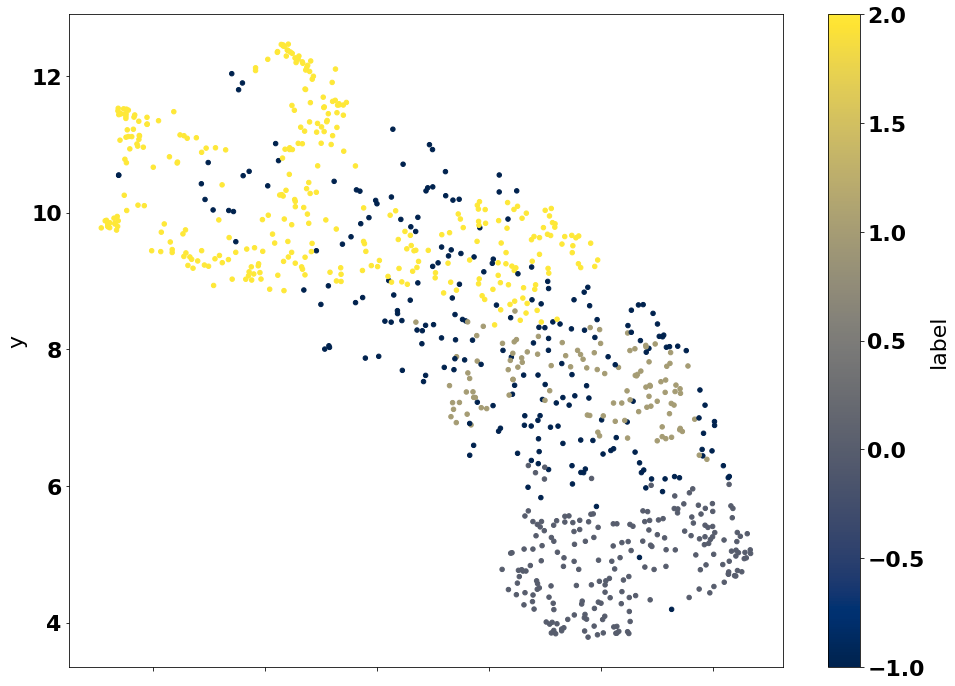

In [273]:
#Now let's plot df_umap_embeddings_2D

df_umap_embeddings_2D.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_embedding_all_24.png')

In [274]:
#Let's create a column with labels in the original dataframe
data['label']=df_umap_embeddings_2D['label']
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,label
0,Not exactly my type of book. I received it for...,1
1,Should be more like four and one-half stars. I...,2
2,Overall I was disappointed. Although WW II su...,1
3,This is an excellent book. The author does a t...,2
4,I loved all the characters. They are also true...,2
...,...,...
865,This was a good read,2
866,"WW II, French resistance, love, danger. Probab...",-1
867,"The book was excellent however, I only gave it...",0
868,An up close and personal look at the heartbrea...,-1


To maintain uniformity with similar analysis on other products, we'll only select those clusters that have a share of larger than 2%.

In [275]:
selected_clusters=[i for i in range(-1,3) if df_umap_embeddings_2D['label'].value_counts(normalize=True)[i]>0.02]
selected_clusters

[-1, 0, 1, 2]

In this case, all clusters have a share over 2% of total number of reviews counts. So for this book, we'll create a plot that includes all the clusters.

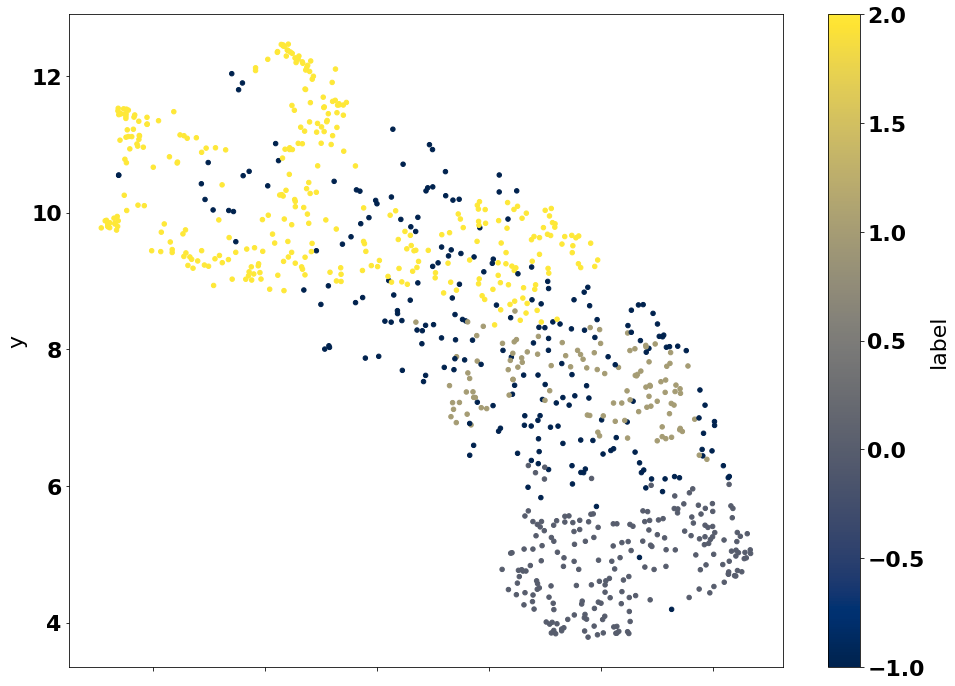

In [276]:
df_umap_embeddings_2D_selected_clusters=df_umap_embeddings_2D[df_umap_embeddings_2D['label'].isin(selected_clusters)]
df_umap_embeddings_2D_selected_clusters.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_embedding_selected_24.png')

It's important to remember that the figure above is a projection of higher dimensional data on a 2D surface. The visual might be a little more illustrative if we plot it in 3D, instead. So let's try that.

In [277]:
umap_embeddings_3D=umap.UMAP(n_neighbors=100,n_components=3,metric='cosine').fit_transform(embeddings)
df_umap_embeddings_3D=pd.DataFrame(umap_embeddings_3D,columns=['x','y','z'])
df_umap_embeddings_3D['label']=clusters.labels_

In [278]:
df_umap_embeddings_3D_selected_clusters

,x,y,z,label
0,0.180301,7.673500,2.377775,-1
1,1.211849,5.715296,5.304604,2
2,-0.174251,7.808657,1.700454,2
3,1.631662,6.774226,4.130980,2
4,-0.110582,6.892935,2.418712,-1
...,...,...,...,...
865,1.057275,5.260148,5.523456,2
866,0.565741,8.274665,-0.636180,0
867,1.016656,7.908254,0.126107,0
868,0.307616,7.102858,1.226512,-1


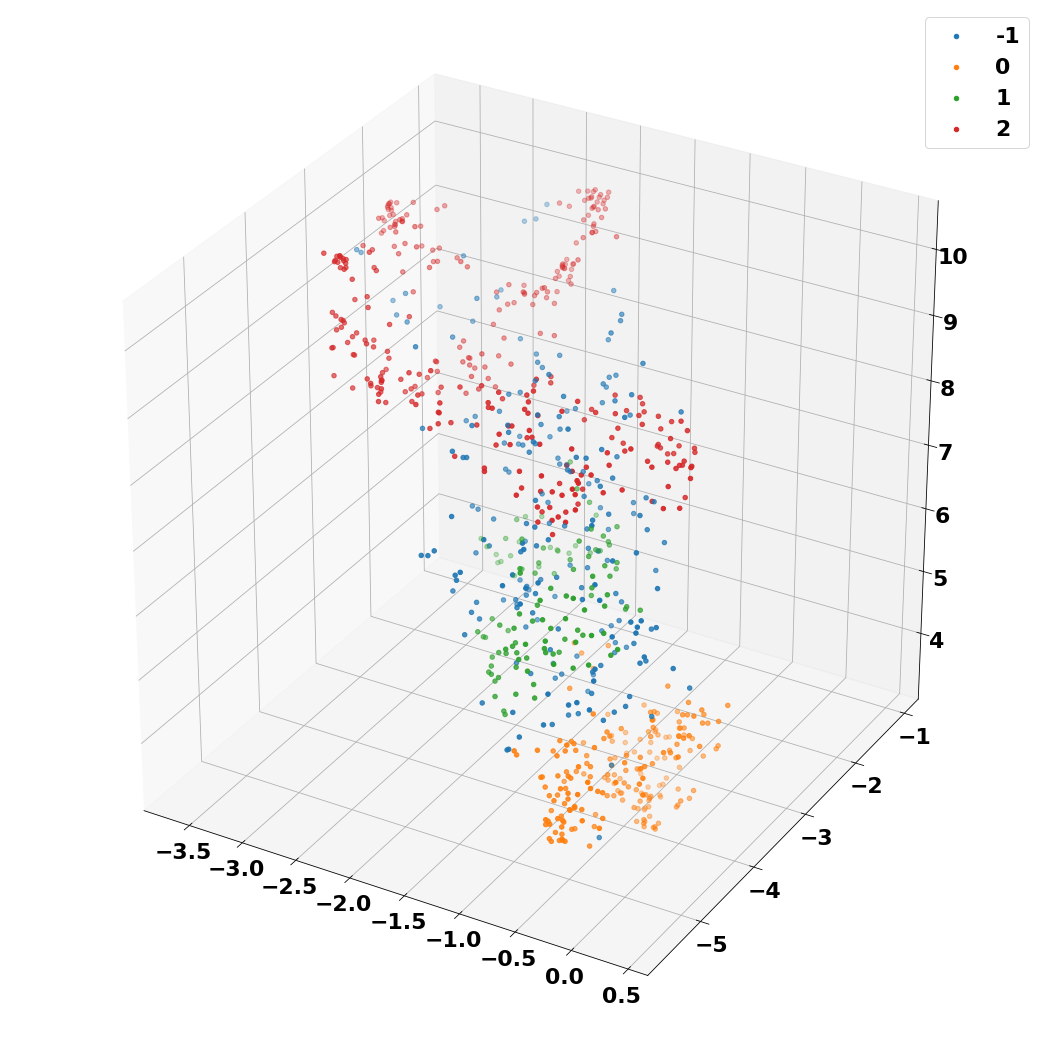

In [281]:
df_umap_embeddings_3D_selected_clusters=df_umap_embeddings_3D[df_umap_embeddings_3D['label'].isin(selected_clusters)]
#df_umap_embeddings_3D_selected_clusters.plot(x='x',y='y',z='z',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

#plot_3d = plt.figure().gca(projection='3d',alpha=0.5,fc='cividis')
#plot_3d.scatter(df_umap_embeddings_3D_selected_clusters['x'], df_umap_embeddings_3D_selected_clusters['y'], df_umap_embeddings_3D_selected_clusters['z'],c = cdict[g], label = g)

#group = selected_clusters
#cdict = 'cividis'

#x=df_umap_embeddings_3D_selected_clusters['x']
#y=df_umap_embeddings_3D_selected_clusters['y']
#z=df_umap_embeddings_3D_selected_clusters['z']

#fig, ax = plt.subplots()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for cluster in selected_clusters:
    ax.scatter(df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['x'],\
               df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['y'],\
               df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['z'],\
               cmap='cividis',label=cluster)
ax.legend()
plt.tight_layout()
plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_3D_embedding_selected_24.png')

In [282]:
#We can label the original dataframe and extract reviews corresponding to each label.

data_selected_clusters=data[data['label'].isin(selected_clusters)].copy(deep=True)
data_selected_clusters

,reviewText,label
0,Not exactly my type of book. I received it for...,1
1,Should be more like four and one-half stars. I...,2
2,Overall I was disappointed. Although WW II su...,1
3,This is an excellent book. The author does a t...,2
4,I loved all the characters. They are also true...,2
...,...,...
865,This was a good read,2
866,"WW II, French resistance, love, danger. Probab...",-1
867,"The book was excellent however, I only gave it...",0
868,An up close and personal look at the heartbrea...,-1


We'll identify the prominent themes in each of these clusters using TF-IDF. Since we'll be performing this operation several times, this is a good place to write an function that would do it for us.

In [283]:
def create_doc(input_dataframe,clusters_to_select):
  docs=[]
  for label in clusters_to_select:
    doc=input_dataframe[input_dataframe['label']==label]
    docs.append(doc)
  return docs

In [284]:
docs=create_doc(data_selected_clusters,selected_clusters)
print(docs)

[                                            reviewText  label
6    It is a book for all to read.  We have so much...     -1
7    I enjoyed this wartime book. The sisters are w...     -1
10   This was a very entertaining book, but somewha...     -1
13   A gripping immersion into the privation and st...     -1
14   Well worth reading.  Emotional read of love, l...     -1
..                                                 ...    ...
852  A good story that incorporates the sacrifices ...     -1
855     Definitely one of Kristin Hannah's best books.     -1
864  Kristin made the war more real than most books...     -1
866  WW II, French resistance, love, danger. Probab...     -1
868  An up close and personal look at the heartbrea...     -1

[218 rows x 2 columns],                                             reviewText  label
5    Good historical novel.  Captures both the horr...      0
12   learned a lot about the french resistance duri...      0
19   Disturbing, but excellent portrayal of 

In [285]:
def docs_TFIDF_vectorizer(docs):
  from sklearn.feature_extraction.text import TfidfVectorizer

  stop_words = text.ENGLISH_STOP_WORDS.union(['00', '10', '100', '12', '15', '16', '20', '200', '24', '25',\
       '2nd', '30', '40', '45', '50', '60', '75', '80', '90','!',"''","'m","'s",',','.','...','He','I','It','My','Of','``',\
        '!',"''","'m","'re","'s",',','-','.','...','9','An','Ca','Do','I','It','S.','``','!',"''","'s",'(',')',',','-','.',\
        'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','&',"'ll",'-D','5',':','?',\
        "'", '0', '1', '2', '3', '4', '6', '7', '8', 'A', 'C', 'D', 'H', 'M', 'O', 'S', '`','#',"'ve",'*','--','..','....','10/10','4/5',';',\
        'As','At','HE','IS','IT','If','In','MY','No','ON','On','PR','SO','So','St','To','US','We','/', 'E', 'N', 'P', 'R', 'T', 'U', 'W', 'Y',\
        '$','%',"'S","'d",'.....','1/2','1/3','105','12-lead','125','14','150','198','1\\23\\18','22','221','27','3-3.5','35','AM','Be','By',\
        'CK','DJ','De','Dr','HM','JE','K.','L','MB','Mr','Ms','R.','TO','W.','YA','B', 'J', 'K', '\\','@','Im','Me','Is','000','100ish','11',\
        '178','191','1945','1st','2015','2016','260','36','360','3rds','3star','55','70','78','80s','86','87','99','_____'])
  
  #initialize TFIDF vectorizer
  vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,4))

  #create an empty list
  tfidf_vectorized_docs=[]

  #loop over the docs
  for doc in docs:
    X=vectorizer.fit_transform(doc['reviewText'])
    tfidf_vectorized_docs.append((vectorizer.get_feature_names(),X))
  
  return tfidf_vectorized_docs

In [286]:
tfidf_data=docs_TFIDF_vectorizer(docs)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['18', '23', 'ca', 'ck', 'dj', 'dr', 'hm', 'im', 'je', 'lead', 'll', 'mb', 'mr', 'ms', 'pr', 'st', 've', 'ya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [287]:
tfidf_data

[(['02',
   '02 nightingale',
   '02 nightingale kristin',
   '02 nightingale kristin hannah',
   '1939',
   '1939 story',
   '1939 story depicts',
   '1939 story depicts cruelities',
   '1941',
   '1941 wish',
   '1941 wish author',
   '1941 wish author explained',
   '1995',
   '1995 having',
   '1995 having wonder',
   '1995 having wonder sister',
   '1995 left',
   '1995 left end',
   '1995 narrator',
   '1995 narrator hadn',
   '1995 narrator hadn told',
   '1995 read',
   '1995 read carried',
   '1995 read carried kindle',
   '32',
   '32 cried',
   '32 cried end',
   '32 cried end recommend',
   '600',
   '600 pages',
   '600 pages author',
   '600 pages author editor',
   '95',
   '95 way',
   '95 way gripping',
   '95 way gripping written',
   'abandoning',
   'abandoning pages',
   'absolutely',
   'absolutely thing',
   'absolutely thing really',
   'absolutely thing really liked',
   'accident',
   'accident wrapped',
   'accident wrapped characters',
   'accident wrapped c

In [288]:
tfidf_data_complete_list=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

In [289]:
selected_clusters

[-1, 0, 1, 2]

The corresponding dataframes with tfidf data maybe called df_unclustered, df_0, df_1, df_2. We can easily assign names, as follows:

In [290]:
[df_unclustered,df_0, df_1, df_2]=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

Let's take a look at couple example to check if this worked.

In [291]:
df_unclustered.head(3)

,02,02 nightingale,02 nightingale kristin,02 nightingale kristin hannah,1939,1939 story,1939 story depicts,1939 story depicts cruelities,1941,1941 wish,1941 wish author,1941 wish author explained,1995,1995 having,1995 having wonder,1995 having wonder sister,1995 left,1995 left end,1995 narrator,1995 narrator hadn,1995 narrator hadn told,1995 read,1995 read carried,1995 read carried kindle,32,32 cried,32 cried end,32 cried end recommend,600,600 pages,600 pages author,600 pages author editor,95,95 way,95 way gripping,95 way gripping written,abandoning,abandoning pages,absolutely,absolutely thing,...,yall playing just thinking,yarn,yarn elegantly,yarn elegantly written,yarn elegantly written descriptions,year,year eager,year eager read,year eager read work,year love,year love goodreads,year love goodreads filled,year old,year old got,year old got ahold,year started,year started couldn,year started couldn know,years,years heart,years heart wrenching,years heart wrenching main,years people,years people lived,years people lived europe,yesterday,yesterday today,yesterday today makes,yesterday today makes book,yoked,yoked dreary,yoked dreary utterly,yoked dreary utterly boring,young,young age,young women,young women change,young women change survive,young women grew,young women grew brave
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
df_0.head(2)

,117,117 isabelle,117 isabelle escorted,117 isabelle escorted escape,118,118 jongh,118 jongh 117,118 jongh 117 isabelle,19,19 year,19 year old,19 year old woman,1939,1939 french,1939 french resistance,1939 french resistance realized,1940,1940 book,1940 book progressed,1940 book progressed story,1940 griped,1940 griped isabelle,1940 griped isabelle familiarity,1940 liberation,1940s,1940s bear,1940s bear witness,1940s bear witness strengthening,1940s exclusively,1940s exclusively expression,1940s exclusively expression heck,1940s france,1940s france series,1940s france series startling,1943,1943 factoid,1943 factoid jumped,1943 factoid jumped immediately,1943 mustang,1943 mustang did,...,yes saved majority,yes saved majority died,youll,youll pick,youll pick copy,young,young belgian,young belgian woman,young belgian woman created,young daughter,young daughter care,young daughter care difficult,young daughter war,young daughter war breaks,young generation,young generation want,young generation want understand,young german,young german captain,young german captain unusual,young girl,young girl 6th,young girl 6th grade,young sisters,young sisters different,young sisters different approaches,young women,young women faced,young women faced difficult,younger,younger single,younger single good,younger single good read,younger sister,younger sister lifelong,younger sister lifelong rules,zookeeper,zookeeper wife,zookeeper wife film,zookeeper wife film recently
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
df_2.head(2)

,1995,1995 unnecessary,1995 unnecessary sort,1995 unnecessary sort took,able,able entire,able entire book,able entire book enjoyed,able pick,able pick weeks,able pick weeks enthralled,absolutely,absolutely fantastic,absolutely fantastic book,absolutely wonderful,accurate,accurate moving,accurate moving characters,actually,actually enjoyed,actually enjoyed reading,actually enjoyed reading experienced,actually finished,actually finished book,actually finished book don,actually liking,actually riveted,actually riveted times,actually riveted times works,actually suggest,actually suggest alongside,actually suggest alongside recommend,actually wasn,actually wasn finished,actually wasn finished actually,adore,adore book,adore book came,adore book came highly,adversity,...,written story feel definitely,written time,written time history,written want,written want stop,written want stop reading,wrong,wrong frame,wrong frame mind,wrong frame mind people,ww2,ww2 book,ww2 book good,ww2 book good characters,ww2 novels,ww2 novels ive,ww2 novels ive read,wwii,wwii books,wwii books feels,wwii books feels necessary,wwii recently,wwii recently reunion,wwii years,wwll,wwll fiction,year,year finish,year finish finished,year finish finished half,year reading,year reading hate,year reading hate happens,years,yes,yes interesting,yes interesting story,yes interesting story excellent,yo,yu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are finally ready to look at the most prominent words for each cluster.

In [298]:
df_unclustered.sum().nlargest(15)

book           5.567942
story          5.366964
read           5.252451
good           3.842633
predictable    3.164368
characters     2.525031
interesting    2.382216
time           2.309432
war            2.271648
written        2.271576
long           2.262661
great          2.257887
wwii           2.192859
reading        2.037564
love           2.002267
dtype: float64

In [299]:
#List comprehension to create separate list for each cluster
n_prominent_words=[df.sum().nlargest(15).index for df in [df_unclustered,df_0, df_1, df_2]]

In [300]:
df_n_prominent_words=pd.DataFrame(n_prominent_words).T
df_n_prominent_words.columns=['df_unclustered','df_0', 'df_1', 'df_2']

In [301]:
df_n_prominent_words

,df_unclustered,df_0,df_1,df_2
0,book,book,book,good
1,story,france,war,read
2,read,story,story,book
3,good,french,read,great
4,predictable,wwii,good,good read
5,characters,war,women,story
6,interesting,read,wwii,enjoyed
7,time,good,written,written
8,war,occupation,time,great read
9,written,sisters,love,great book


### These are quick impressions on the clusters based on just the words with high TF-IDF values. 

**df_unclustered:**  Reviewers generally (unclustered readers) saw it as a well written novel on love and war. Although they found the story predictable, they found the characters well developed and enjoyed the story overall.

**df_0:**   Reviewers in cluster 0 focused on the history and geographical significance of events and locations in this story.

**df_1:**   Reviewers in cluster 1 saw the story as a well written novel in the historical romance genre. While not entirely clear from the list, it appears their reviews emphasized the role women characters played in the book. 

**df_2:**  Reviewers in this cluster found the story very enjoyable and didn't have anything negative to say about the book.      

In [304]:
def salient_terms(i):
  pyLDAvis.enable_notebook()

  from sklearn.feature_extraction.text import TfidfVectorizer

  stop_words = text.ENGLISH_STOP_WORDS.union(['00', '10', '100', '12', '15', '16', '20', '200', '24', '25',\
      '2nd', '30', '40', '45', '50', '60', '75', '80', '90','!',"''","'m","'s",',','.','...','He','I','It','My','Of','``',\
      '!',"''","'m","'re","'s",',','-','.','...','9','An','Ca','Do','I','It','S.','``','!',"''","'s",'(',')',',','-','.',\
      'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','&',"'ll",'-D','5',':','?',\
      "'", '0', '1', '2', '3', '4', '6', '7', '8', 'A', 'C', 'D', 'H', 'M', 'O', 'S', '`','#',"'ve",'*','--','..','....','10/10','4/5',';',\
      'As','At','HE','IS','IT','If','In','MY','No','ON','On','PR','SO','So','St','To','US','We','/', 'E', 'N', 'P', 'R', 'T', 'U', 'W', 'Y',\
      '$','%',"'S","'d",'.....','1/2','1/3','105','12-lead','125','14','150','198','1\\23\\18','22','221','27','3-3.5','35','AM','Be','By',\
      'CK','DJ','De','Dr','HM','JE','K.','L','MB','Mr','Ms','R.','TO','W.','YA','B', 'J', 'K', '\\','@','Im','Me','Is','000','100ish','11',\
      '178','191','1945','1st','2015','2016','260','36','360','3rds','3star','55','70','78','80s','86','87','99','_____'])
  vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,4),max_features=1000)
  X=vectorizer.fit_transform(df_n_prominent_words.iloc[:,i])
  lda=LatentDirichletAllocation(n_components=3,random_state=22)
  lda.fit(X)
  p=pyLDAvis.sklearn.prepare(lda,X,vectorizer,R=3)
  pyLDAvis.save_html(p,'/content/drive/My Drive/amazon_reviews_project/images/LDA_File_unclustered_group_24.html')
  return p

salient_terms(2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['18', '23', 'ca', 'ck', 'dj', 'dr', 'hm', 'im', 'je', 'lead', 'll', 'mb', 'mr', 'ms', 'pr', 'st', 've', 'ya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
0      0.093601  1.258624e-08       1        1  39.882284
1     -0.046800 -7.024283e-02       2        1  30.058858
2     -0.046800  7.024282e-02       3        1  30.058858, topic_info=       Term      Freq     Total Category  logprob  loglift
12    women  1.000000  1.000000  Default   3.0000   3.0000
5      love  1.000000  1.000000  Default   2.0000   2.0000
11      war  1.000000  1.000000  Default   1.0000   1.0000
4      like  0.663045  0.999997   Topic1  -2.1997   0.5083
8   reading  0.663045  0.999997   Topic1  -2.1997   0.5083
9     story  0.663045  0.999997   Topic1  -2.1997   0.5083
3     great  0.664393  1.000002   Topic2  -1.9149   0.7931
2      good  0.664393  1.000002   Topic2  -1.9149   0.7931
10     time  0.664393  1.000002   Topic2  -1.9149   0.7931
12    women  0.664393  1.000002   Topic3  -1.9149   0.7931
5      love  0.664393  1.000002   Topic3  -1.9149   0.7931
11      war  0.664393  1.000002   Topic3  -1.9149   0.7931, token_table=      Topic      Freq     Term
term                          
2         2  0.999998     good
3         2  0.999998    great
4         1  1.000003     like
5         3  0.999998     love
8         1  1.000003  reading
9         1  1.000003    story
10        2  0.999998     time
11        3  0.999998      war
12        3  0.999998    women, R=3, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Product Reveal
### The Nightingale: A Novel
### Synopsis:
**A #1 New York Times bestseller, Wall Street Journal Best Book of the Year, and soon to be a major motion picture, this unforgettable novel of love and strength in the face of war has enthralled a generation.**

France, 1939 - In the quiet village of Carriveau, Vianne Mauriac says goodbye to her husband, Antoine, as he heads for the Front. She doesn't believe that the Nazis will invade France … but invade they do, in droves of marching soldiers, in caravans of trucks and tanks, in planes that fill the skies and drop bombs upon the innocent. When a German captain requisitions Vianne's home, she and her daughter must live with the enemy or lose everything. Without food or money or hope, as danger escalates all around them, she is forced to make one impossible choice after another to keep her family alive.